In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
from DataLoader import Rescale, EyeDataSet, show_batch 

In [3]:
scale = Rescale((224,224))

In [5]:
transformed_dataset = EyeDataSet('./data/dataset.csv','./data/train_data/compressed',transform=scale)
dataloader = DataLoader(transformed_dataset, batch_size=16,shuffle=True, num_workers=0)

0 torch.Size([16, 224, 224, 3])


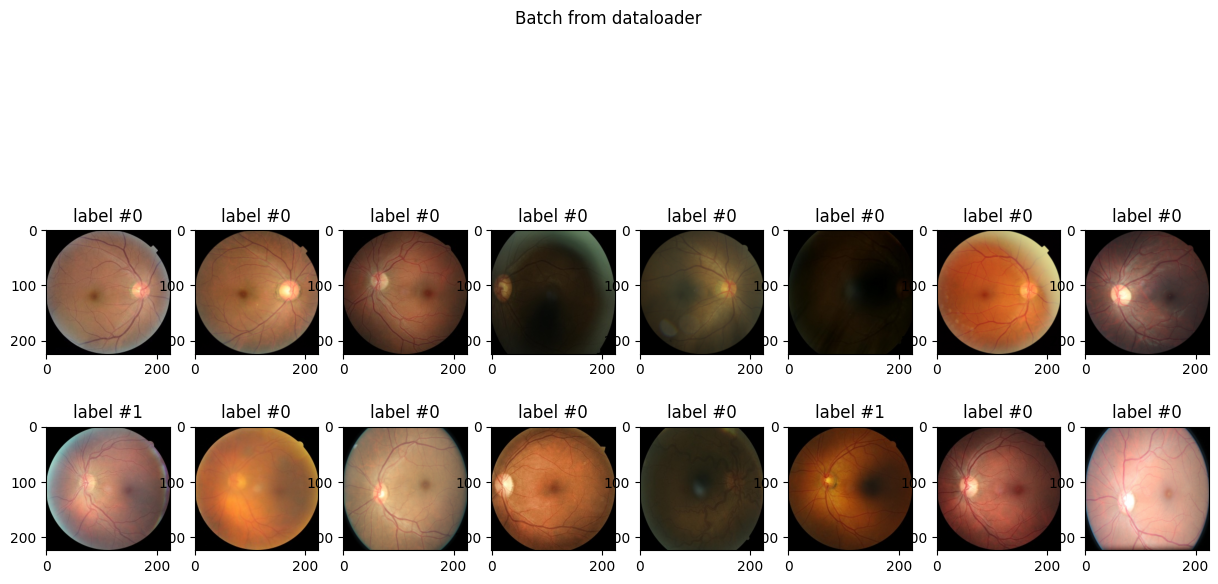

In [7]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 0:
        show_batch(sample_batched)
        break

image name:./data/train_data/compressed/10_left.jpeg, image shape(224, 224, 3)
transformed image shape(224, 224, 3)


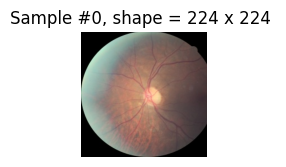

image name:./data/train_data/compressed/10_right.jpeg, image shape(224, 224, 3)
transformed image shape(224, 224, 3)


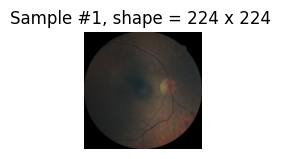

image name:./data/train_data/compressed/13_left.jpeg, image shape(224, 224, 3)
transformed image shape(224, 224, 3)


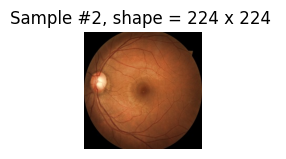

image name:./data/train_data/compressed/13_right.jpeg, image shape(224, 224, 3)
transformed image shape(224, 224, 3)


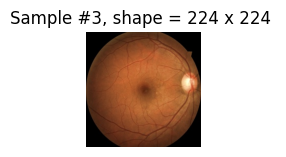

In [120]:
fig = plt.figure()


for i,dict in enumerate(transformed_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}, shape = {dict["image"].shape[0]} x {dict["image"].shape[1]} '.format(i))
    ax.axis('off')
    plt.imshow(dict['image'])
    plt.pause(0.001)
    
    if i == 3:
        plt.show()
        break

In [5]:
pd.read_csv('./data/dataset.csv').iloc[12,1]

'20_left.jpeg'

In [ ]:
EyeDataLoader('')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [3]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.5986, 0.0301, 0.5968, 0.3222, 0.0552, 0.0400, 0.9288, 0.4983, 0.9595,
         0.7621],
        [0.3319, 0.1937, 0.8226, 0.4642, 0.4707, 0.7647, 0.2086, 0.8937, 0.8244,
         0.7503],
        [0.7784, 0.5915, 0.8257, 0.7852, 0.1292, 0.3055, 0.3628, 0.1946, 0.4602,
         0.3925],
        [0.2471, 0.8252, 0.2132, 0.7869, 0.7183, 0.4016, 0.1258, 0.8456, 0.8889,
         0.8569]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.2665224075317383


In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1